In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import random
from tqdm import tqdm
import collections
import matplotlib.pyplot as plt


class WorldEnv:
    def __init__(self):
        # distance threshold
        self.distance_threshold = 0.15
        # action bound
        self.action_bound = 1

    def reset(self):  # 重置环境
        # 生成一个目标状态, 坐标范围是[3.5～4.5, 3.5～4.5]
        self.goal = np.array(
            [4 + random.uniform(-0.5, 0.5), 4 + random.uniform(-0.5, 0.5)])
        # 初始状态
        self.state = np.array([0, 0])  
        # 记录步数
        self.count = 0
        return np.hstack((self.state, self.goal))

    def step(self, action):
        # clipping the action value
        action = np.clip(action, -self.action_bound, self.action_bound)
        # update the state based on action value
        x = max(0, min(5, self.state[0] + action[0]))
        y = max(0, min(5, self.state[1] + action[1]))
        self.state = np.array([x, y])
        # update the step counter
        self.count += 1

        # calculate the distance to the goal
        dis = np.sqrt(np.sum(np.square(self.state - self.goal)))
        # reward function
        reward = -1.0 if dis > self.distance_threshold else 0
        # check whether the episode is done
        if dis <= self.distance_threshold or self.count == 50:
            done = True
        else:
            done = False

        return np.hstack((self.state, self.goal)), reward, done

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim) # 全连接层，输入维度是state_dim，输出维度是hidden_dim
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim) # 全连接层，输入维度是hidden_dim，输出维度是hidden_dim
        self.fc3 = torch.nn.Linear(hidden_dim, action_dim) # 全连接层，输入维度是hidden_dim，输出维度是action_dim
        self.action_bound = action_bound  # action_bound是环境可以接受的动作最大值

    def forward(self, x):
        x = F.relu(self.fc2(F.relu(self.fc1(x)))) # 两个relu激活函数，先是fc1层，再是fc2层
        return torch.tanh(self.fc3(x)) * self.action_bound # tanh激活函数，fc3层


class QValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)  # 状态和动作拼接后输入的全连接层
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)  # 隐藏层1
        self.fc3 = torch.nn.Linear(hidden_dim, 1)  # 隐藏层2

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)  # 拼接状态和动作
        x = F.relu(self.fc2(F.relu(self.fc1(cat))))  # 隐藏层1
        return self.fc3(x)  # 输出层

In [3]:
class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, sigma, tau, gamma, device):
        self.action_dim = action_dim
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim,
                               action_bound).to(device)
        self.critic = QValueNet(state_dim, hidden_dim, action_dim).to(device)
        self.target_actor = PolicyNet(state_dim, hidden_dim, action_dim,
                                      action_bound).to(device)
        self.target_critic = QValueNet(state_dim, hidden_dim,
                                       action_dim).to(device)
        # 初始化目标价值网络并使其参数和价值网络一样
        self.target_critic.load_state_dict(self.critic.state_dict())
        # 初始化目标策略网络并使其参数和策略网络一样
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.sigma = sigma  # 高斯噪声的标准差,均值直接设为0
        self.tau = tau  # 目标网络软更新参数
        self.action_bound = action_bound
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state).detach().cpu().numpy()[0]
        # 给动作添加噪声，增加探索
        action = action + self.sigma * np.random.randn(self.action_dim)
        return action

    def soft_update(self, net, target_net):
        # for each parameter in the target network
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            # copy the parameter from the network to the target network
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        next_q_values = self.target_critic(next_states,
                                           self.target_actor(next_states))
        q_targets = rewards + self.gamma * next_q_values * (1 - dones) # 计算Q目标值
        # MSE损失函数
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states, actions), q_targets))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # 策略网络就是为了使Q值最大化
        actor_loss = -torch.mean(self.critic(states, self.actor(states)))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.actor, self.target_actor)  # 软更新策略网络
        self.soft_update(self.critic, self.target_critic)  # 软更新价值网络

In [4]:
class Trajectory:
    ''' 用来记录一条完整轨迹 '''
    def __init__(self, init_state):
        self.states = [init_state] # 记录轨迹中的状态
        self.actions = [] # 记录轨迹中的动作
        self.rewards = [] # 记录轨迹中的奖励
        self.dones = [] # 记录轨迹中的中断标记
        self.length = 0 # 记录轨迹的长度

    def store_step(self, action, state, reward, done):
        self.actions.append(action)
        self.states.append(state)
        self.rewards.append(reward)
        self.dones.append(done)
        self.length += 1


class ReplayBuffer_Trajectory:
    ''' 存储轨迹的经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add_trajectory(self, trajectory):
        self.buffer.append(trajectory)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size, use_her, dis_threshold=0.15, her_ratio=0.8):
        batch = dict(states=[],
                     actions=[],
                     next_states=[],
                     rewards=[],
                     dones=[])
        for _ in range(batch_size):
            # 从缓存中随机抽取一个轨迹
            traj = random.sample(self.buffer, 1)[0]
            # 从轨迹中随机抽取一个步骤
            step_state = np.random.randint(traj.length)
            state = traj.states[step_state]
            next_state = traj.states[step_state + 1]
            action = traj.actions[step_state]
            reward = traj.rewards[step_state]
            done = traj.dones[step_state]

            if use_her and np.random.uniform() <= her_ratio:
                # 使用HER算法的future方案设置目标
                step_goal = np.random.randint(step_state + 1, traj.length + 1)
                goal = traj.states[step_goal][:2]
                dis = np.sqrt(np.sum(np.square(next_state[:2] - goal)))
                # 根据当前状态与目标的距离来设置奖励
                reward = -1.0 if dis > dis_threshold else 0
                done = False if dis > dis_threshold else True
                # 将目标加入到状态中
                state = np.hstack((state[:2], goal))
                next_state = np.hstack((next_state[:2], goal))

            batch['states'].append(state)
            batch['next_states'].append(next_state)
            batch['actions'].append(action)
            batch['rewards'].append(reward)
            batch['dones'].append(done)

        batch['states'] = np.array(batch['states'])
        batch['next_states'] = np.array(batch['next_states'])
        batch['actions'] = np.array(batch['actions'])
        return batch

In [5]:
class Trajectory: # 用来记录一条完整轨迹
    def __init__(self, init_state):
        self.states = [init_state] # 存储状态
        self.actions = [] # 存储动作
        self.rewards = [] # 存储奖励
        self.dones = [] # 存储episode是否结束
        self.length = 0 # 轨迹长度

    def store_step(self, action, state, reward, done):
        self.actions.append(action)
        self.states.append(state)
        self.rewards.append(reward)
        self.dones.append(done)
        self.length += 1


class ReplayBuffer_Trajectory:
    ''' 存储轨迹的经验回放池 '''
    def __init__(self, capacity):
        # 经验回放池的容量
        self.buffer = collections.deque(maxlen=capacity)

    def add_trajectory(self, trajectory):
        # 添加轨迹
        self.buffer.append(trajectory)

    def size(self):
        # 返回经验回放池的大小
        return len(self.buffer)

    def sample(self, batch_size, use_her, dis_threshold=0.15, her_ratio=0.8):
        # 从经验回放池中采样轨迹
        batch = dict(states=[],
                     actions=[],
                     next_states=[],
                     rewards=[],
                     dones=[])
        for _ in range(batch_size):
            # 从经验回放池中随机采样一个轨迹
            traj = random.sample(self.buffer, 1)[0]
            # 从该轨迹中随机采样一个状态
            step_state = np.random.randint(traj.length)
            state = traj.states[step_state]
            next_state = traj.states[step_state + 1]
            action = traj.actions[step_state]
            reward = traj.rewards[step_state]
            done = traj.dones[step_state]

            if use_her and np.random.uniform() <= her_ratio:
                # 使用HER算法的future方案设置目标
                step_goal = np.random.randint(step_state + 1, traj.length + 1)
                goal = traj.states[step_goal][:2]
                dis = np.sqrt(np.sum(np.square(next_state[:2] - goal)))
                reward = -1.0 if dis > dis_threshold else 0
                done = False if dis > dis_threshold else True
                state = np.hstack((state[:2], goal))
                next_state = np.hstack((next_state[:2], goal))

            batch['states'].append(state)
            batch['next_states'].append(next_state)
            batch['actions'].append(action)
            batch['rewards'].append(reward)
            batch['dones'].append(done)

        batch['states'] = np.array(batch['states'])
        batch['next_states'] = np.array(batch['next_states'])
        batch['actions'] = np.array(batch['actions'])
        return batch

Iteration 9: 100%|██████████| 200/200 [01:01<00:00,  3.26it/s, episode=2000, return=-4.100]


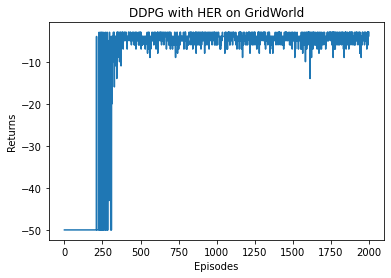

In [6]:
actor_lr = 1e-3
critic_lr = 1e-3
hidden_dim = 128
state_dim = 4
action_dim = 2
action_bound = 1
sigma = 0.1
tau = 0.005
gamma = 0.98
num_episodes = 2000
n_train = 20
batch_size = 256
minimal_episodes = 200
buffer_size = 10000
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
env = WorldEnv()
replay_buffer = ReplayBuffer_Trajectory(buffer_size)
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, actor_lr,
             critic_lr, sigma, tau, gamma, device)

# initialize variables
return_list = []
# loop over iterations
for i in range(10):
    # initialize progress bar
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        # loop over episodes
        for i_episode in range(int(num_episodes / 10)):
            # initialize episode return
            episode_return = 0
            # initialize environment
            state = env.reset()
            traj = Trajectory(state)
            done = False
            # loop over environment steps
            while not done:
                # take action
                action = agent.take_action(state)
                # take step
                state, reward, done = env.step(action)
                # update episode return
                episode_return += reward
                # store step
                traj.store_step(action, state, reward, done)
            # add trajectory to replay buffer
            replay_buffer.add_trajectory(traj)
            # add episode return to return list
            return_list.append(episode_return)
            # check if replay buffer contains enough trajectories for training
            if replay_buffer.size() >= minimal_episodes:
                # loop over training steps
                for _ in range(n_train):
                    # sample transitions from replay buffer
                    transition_dict = replay_buffer.sample(batch_size, True)
                    # update agent
                    agent.update(transition_dict)
            # update progress bar
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG with HER on {}'.format('GridWorld'))
plt.show()

Iteration 9: 100%|██████████| 200/200 [00:36<00:00,  5.55it/s, episode=2000, return=-14.600]


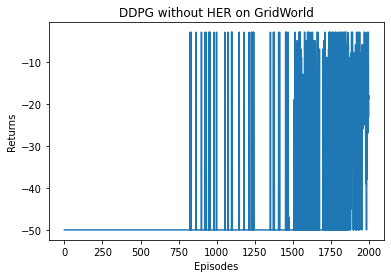

In [7]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
env = WorldEnv()
replay_buffer = ReplayBuffer_Trajectory(buffer_size)
agent = DDPG(state_dim, hidden_dim, action_dim, action_bound, actor_lr,
             critic_lr, sigma, tau, gamma, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            traj = Trajectory(state)
            done = False
            while not done:
                action = agent.take_action(state)
                state, reward, done = env.step(action)
                episode_return += reward
                traj.store_step(action, state, reward, done)
            replay_buffer.add_trajectory(traj)
            return_list.append(episode_return)
            if replay_buffer.size() >= minimal_episodes:
                for _ in range(n_train):
                    # 和使用HER训练的唯一区别
                    transition_dict = replay_buffer.sample(batch_size, False)
                    agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DDPG without HER on {}'.format('GridWorld'))
plt.show()